# Methods

## Deep Learning Models
**Data**: Similar to the non-deep models, the filepaths and the corresponding labels from the "metadata.csv" file form the X and y variables respectively with a train test split of 80%/20%. The make_dataset_deep.py file is used to extract the features such as Linear Spectrogram, Mel Spectrogram or MFCC from the wav file at each filepath location which are then used as the input tensors for the models.

The code below demonstrates the data creation using the Mel Spectrogram features from the py file.

In [ ]:
from make_dataset_deep import make_filepaths_labels, train_test_split_deep # Importing the py file for creating the tensors with features

# A list of features that can be built from the input data
features = ['LinearSpectrogram', 'MelSpectrogram', 'MFCC']
# Path to the metadata csv file
metadata_path = '/content/drive/MyDrive/Bird_Sounds/bird_songs_metadata.csv'
# Path to all the audio files
audio_path = '/content/drive/MyDrive/Bird_Sounds/wavfiles/'
# Storing the filepaths and the corresponding labels in a list forming the X and y variables respectively.
file_paths, labels = make_filepaths_labels(metadata_path, audio_path)
# Creating the training and testing data using the MelSpectrogram as the features
dataset_train, dataset_test = train_test_split_deep(file_paths, labels, features[1])
# Verifying the shape of input data
for batch in dataset_train.take(1):
      input_data_shape = batch[0].shape
      print("Shape of the input data:", input_data_shape)

Shape of the input data: (64, 1026, 128)


The shape of our input data is 3 dimensional:
1. The first dimension (64) is the batch size.
2. The second dimension (1026) are the time steps where each step is approximately 2.9 milliseconds.
3. The third dimension (128) is the number of frequency bins. In case of a Linear Spectrogram, the number of frequency bins would be 257.

**Models:** All deep models are implemented in TensorFlow. A Convolutional Neural Network (CNN) is used with 4 convolutional blocks. The architecture resembles the architecture of the CNN model from the Kaggle competition. The number of filters for each convolution layer is modified from 128 to 64 in order to match the shape of Mel Spectrogram since the CNN architecture used in the competition was meant for Linear Spectrogram input only.

The code below demonstrates the CNN model creation using create_model_deep.py file and prints the model summary.

In [ ]:
from create_model_deep import create_model_CNN # Importing the py file for creating the model

# Calling the function that creates the model
model = create_model_CNN()
# Print the architecture
print(model.summary())

Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Input_shape (InputLayer)  [(None, 1026, 128)]       0         
                                                                 
 1_Conv1D (Conv1D)           (None, 513, 64)           65600     
                                                                 
 2_SpatialDropout1D (Spatia  (None, 513, 64)           0         
 lDropout1D)                                                     
                                                                 
 3_Conv1d (Conv1D)           (None, 257, 64)           32832     
                                                                 
 4_SpatialDropout1D (Spatia  (None, 257, 64)           0         
 lDropout1D)                                                     
                                                                 
 5_Conv1d (Conv1D)           (None,

As mentioned previously, the CNN consists of 4 convolutional blocks where each block comprises of a convolution layer followed by a dropout layer to handle overfitting. A global average pooling layer is applied at the end of the convolutional blocks followed by a fully connected dense layer, dropout layer and the classifier layer. The total number of learnable weights and biases is approximately 200k.


A CNN+RNN architecture is employed as well so the model can learn and remember the evolution of features over time. The last convolutional block of the CNN layer is replaced by a bidirectional GRU cell (RNN) followed by an attention layer. A bidirectional instead of a unidirectional GRU cell is used in order to capture both forward and backward context of the input sequence. An attention layer is incorporated because it enhances the performance of the GRU cell by directing the model's attention to specific segments of the input sequence that are important for prediction.

The code below demonstrates the CNN+RNN model creation using create_model_deep.py file and prints the model summary.

In [ ]:
from create_model_deep import create_model_CNN_RNN # Importing the function for creating the CNN+RNN model

# Calling the function that creates the model
model = create_model_CNN_RNN()
# Print the architecture
print(model.summary())

Model: "Bird_audio_classification_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 0_Input_shape (InputLayer)  [(None, 1026, 128)]          0         []                            
                                                                                                  
 1_Conv1D (Conv1D)           (None, 513, 64)              65600     ['0_Input_shape[0][0]']       
                                                                                                  
 2_SpatialDropout1D (Spatia  (None, 513, 64)              0         ['1_Conv1D[0][0]']            
 lDropout1D)                                                                                      
                                                                                                  
 3_Conv1d (Conv1D)           (None, 257, 64)              32832     

The addition of the RNN and the attention layer in place of the fourth convolutional block increased the total number of parameters from approximately 200k to 250k.

**Model Configuration:** Adam optimizer is employed for all the models with an initial learning rate of 0.001 which gets cut in half after every 4000 steps. The batch size is set to 64. 'SparseCategoricalCrossentropy' loss function is utilized. The best model is saved across all epochs based on the 'SparseCategoricalAccuracy' score. Losses and accuracy scores are logged in TensorBoard.






# Evaluation

## CNN model with Mel Spectrogram Features
**Model Performance:** The CNN model is trained for 60 epochs reaching an accuracy score of 95.51%. It outperforms all the non-deep simpler models.


In [ ]:
from predict_model_deep import model_load_predict # Importing the function to load and get model predictions
from visualisations_deep_models import print_evaluation_metrics # Importing the function to print the evaluation metrics
# Loading the trained model and getting the probabilities, predictions and the true labels
y_prob, y_pred, y_true = model_load_predict('/content/model', dataset_test)
# Printing the evaluation metrics
print_evaluation_metrics(y_true, y_pred, y_prob)

16/16 [==============================] - 3s 133ms/step - loss: 0.1740 - sparse_categorical_accuracy: 0.9551
{'loss': 0.17404751479625702, 'sparse_categorical_accuracy': 0.955078125}
16/16 [==============================] - 2s 126ms/step
Evaluation Metrics
F1: 0.96 | Precision: 0.96 | Recall: 0.96


The average F1, precision and recall scores indicate that the model is very effective in correctly predicting the positive instances and maintains a very low rate of false positives and false negatives.

**Train and Test Loss Curves**

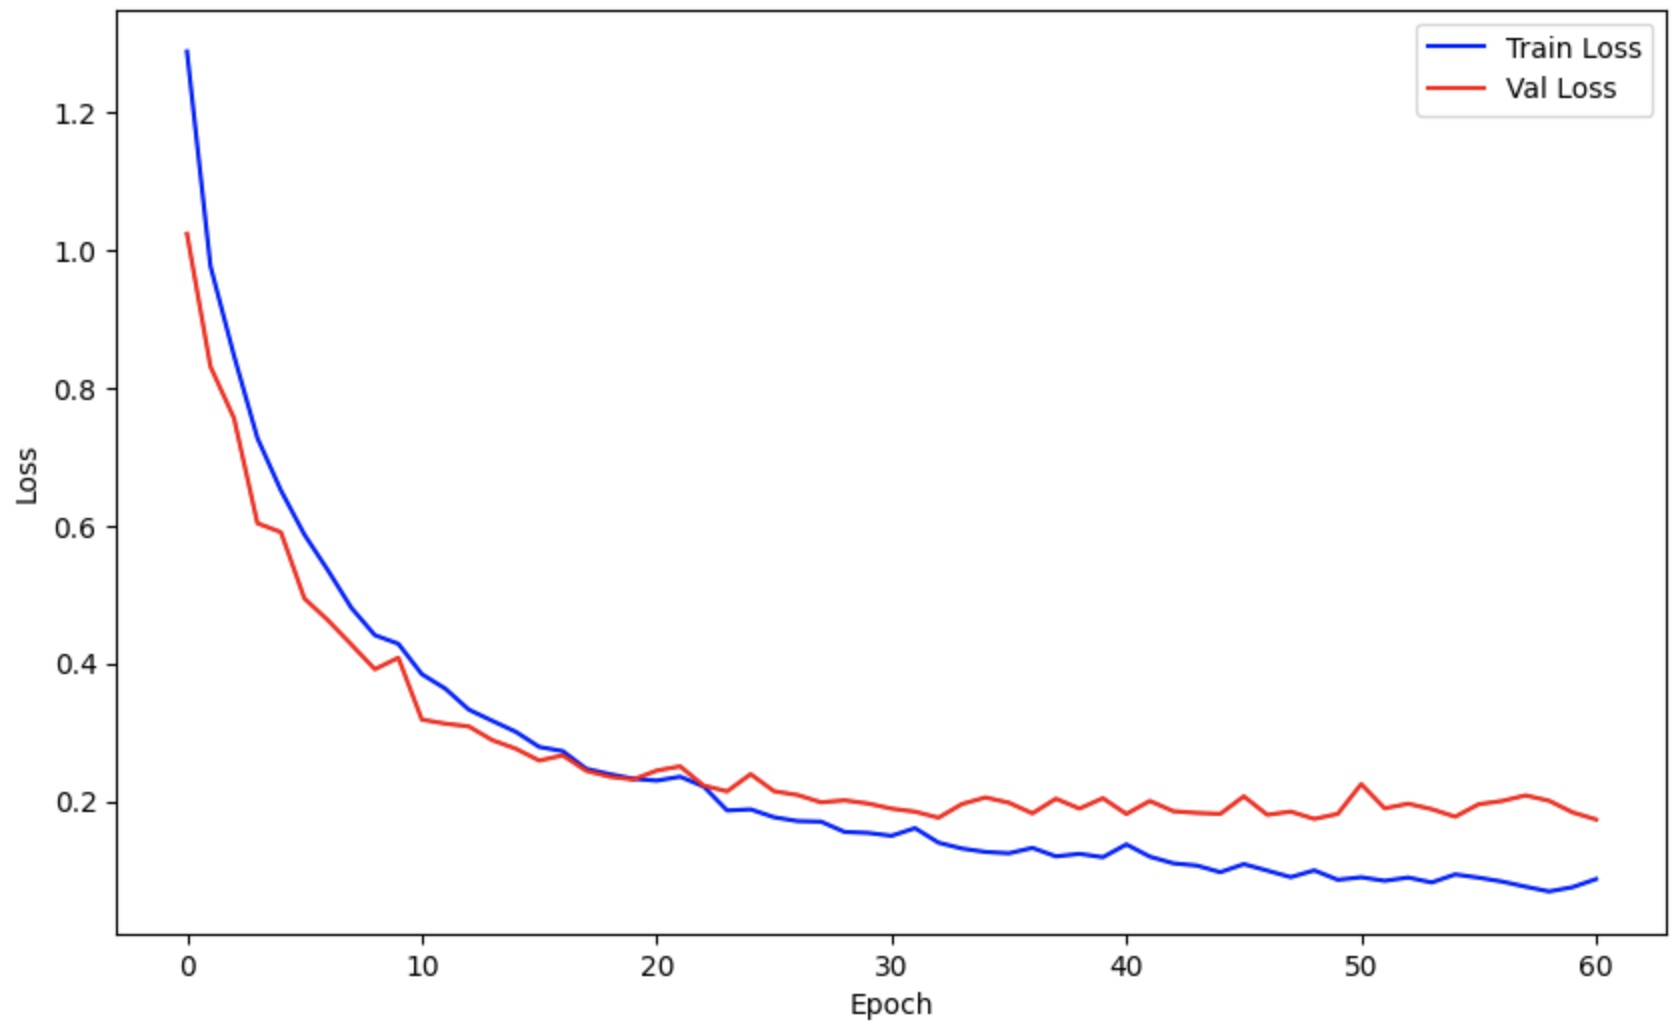



The loss curves indicate that the model is well-trained and does not exhibit signs of overfitting.


**Confusion Matrix**

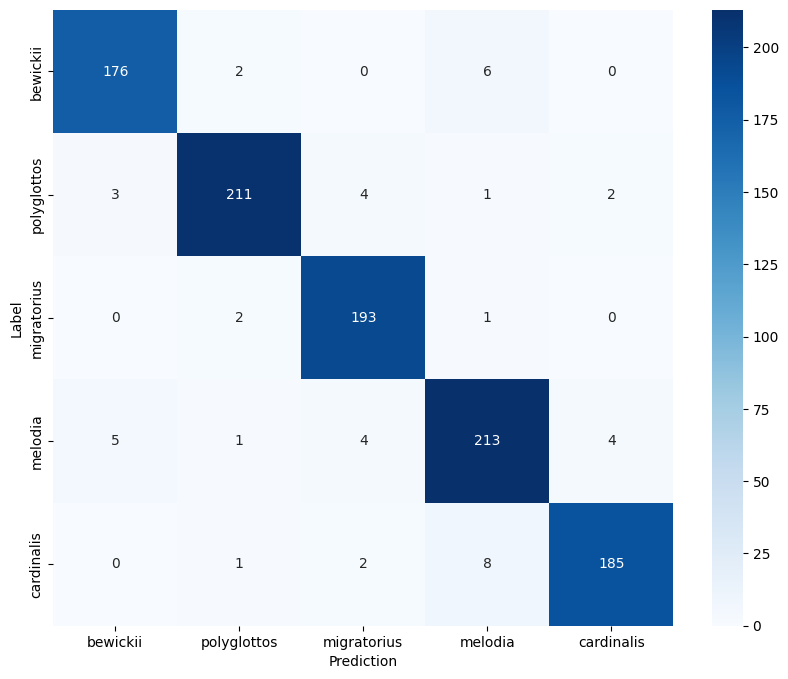

In [ ]:
from visualisations_deep_models import visualize_confusion_matrix # Importing the function to visualise the confusion matrix

 # Visualising the confusion matrix
visualize_confusion_matrix(y_true, y_pred)

The model gets confused between melodia and bewickii. It misclassifies 6 samples from bewickii as melodia and 5 samples from melodia as bewickii. Also, there are 8 cardinalis samples that are mislabeled as melodia.

**Model Interpretation (Saliency Map)**


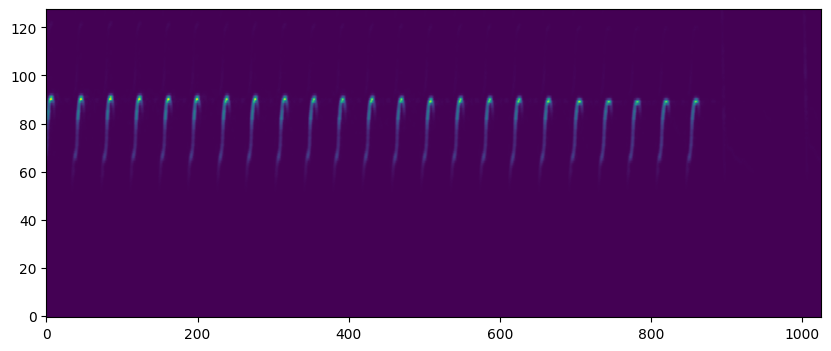

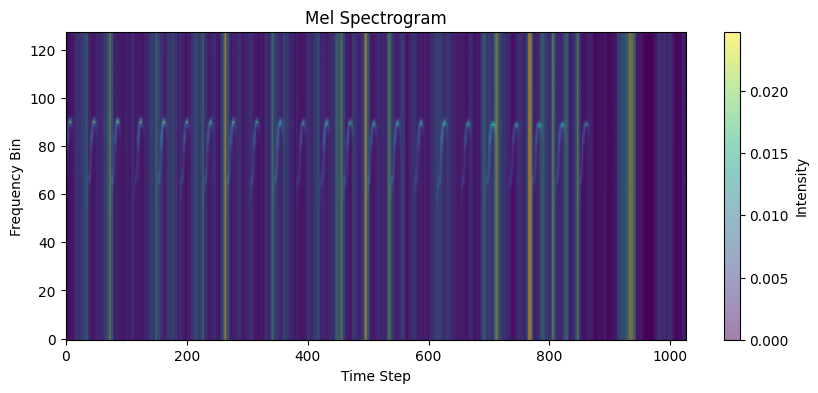

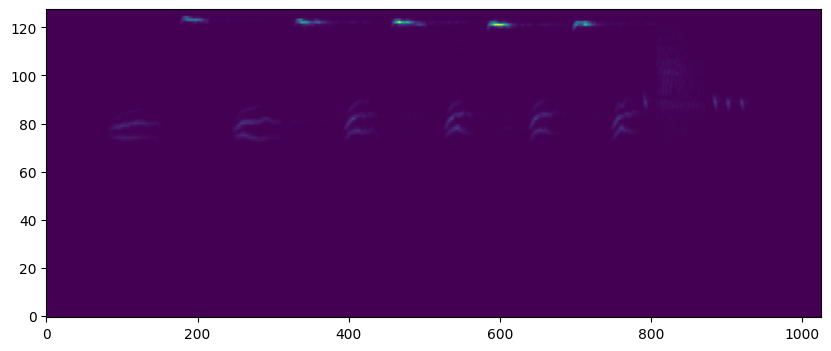

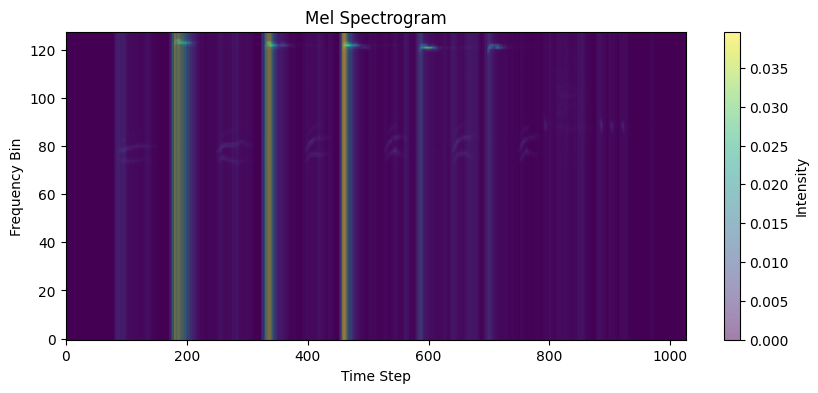

In [ ]:
import tensorflow as tf
from visualisations_deep_models import visualize_saliency_map # Importing the function to visualise the model interpretation

 # Visualising the model interpretation
visualize_saliency_map(tf.keras.models.load_model('/content/model'), dataset_test, [0, 50])

The Saliency Maps above reveal that the model focuses on the distinct features, highlighted in yellow, formed on the mel spectrogram for classification.

## CNN+RNN Model with Mel Spectrogram Features

**Model Performance:** The model is trained for 120 epochs since there are more parameters than that of the CNN model. While training, the model exhibits signs of overfitting around 80 epochs as displayed in the test loss curve below.

**Test Loss Curve**

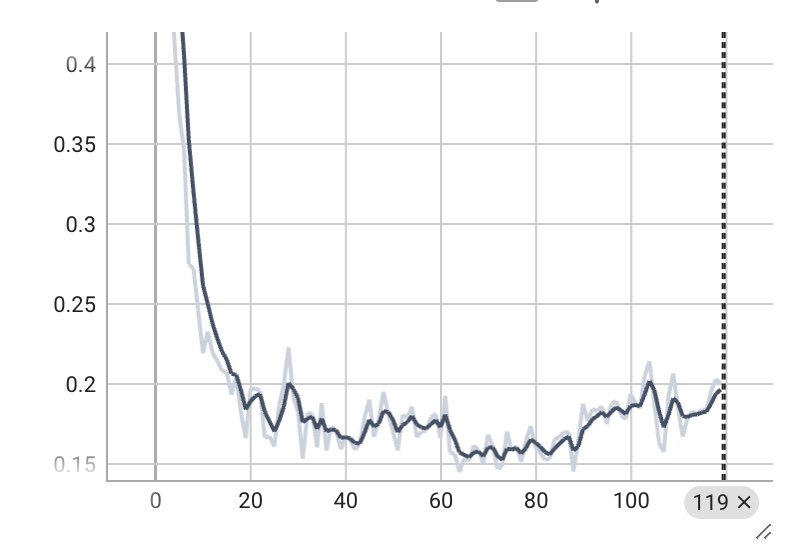




In order to remove overfitting, L2 regularization is applied to the 2nd convolution layer in addition to the dropout layer.

**Test Loss Curve After Regularization**
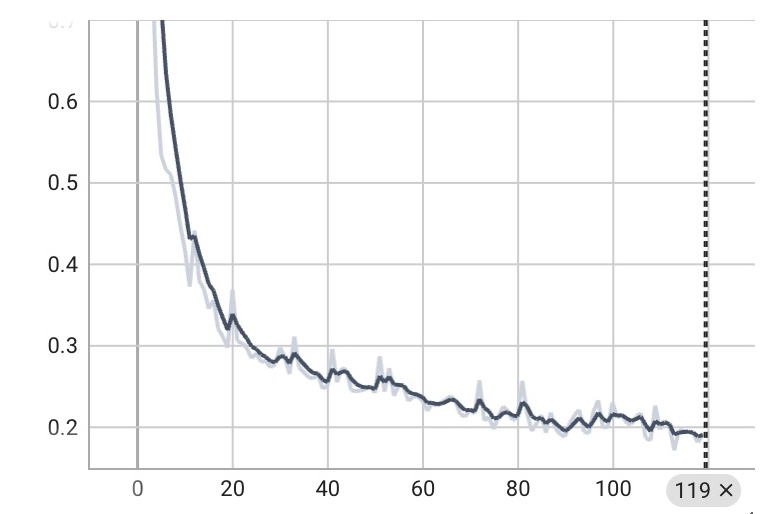

The test curve indicates that the model is not overfitting anymore.

In [23]:
# Loading the trained model and getting the probabilities, predictions and the true labels
y_prob, y_pred, y_true = model_load_predict('/content/model_v2', dataset_test)
# Printing the evaluation metrics
print_evaluation_metrics(y_true, y_pred, y_prob)

16/16 [==============================] - 3s 117ms/step - loss: 0.1718 - sparse_categorical_accuracy: 0.9668
{'loss': 0.17180003225803375, 'sparse_categorical_accuracy': 0.966796875}
16/16 [==============================] - 3s 123ms/step
Evaluation Metrics
F1: 0.97 | Precision: 0.97 | Recall: 0.97


The model reaches an accuracy score of 96.68% which is slightly better than the CNN model. The average F1, precision and recall scores show a slight improvement as well.

**Confusion Matrix**



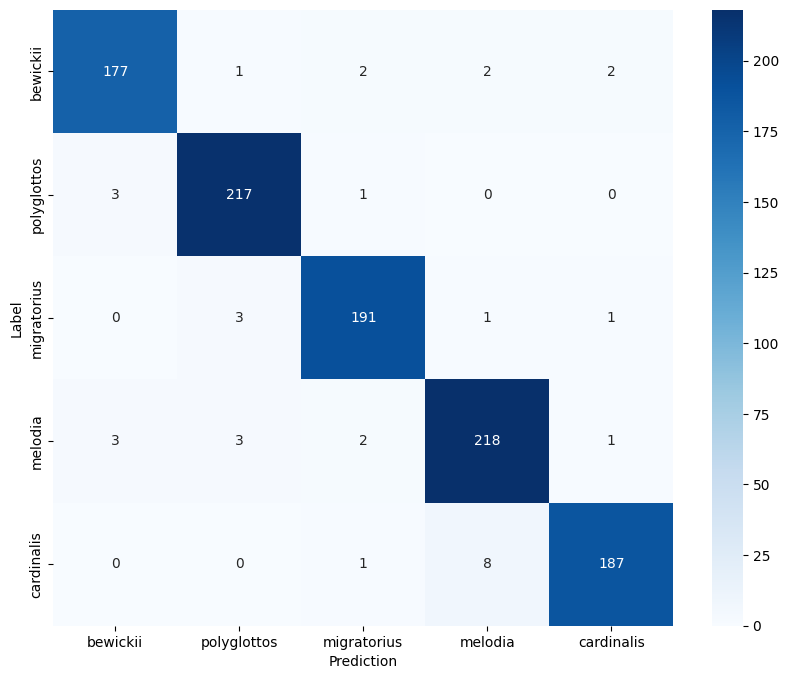

In [24]:
 # Visualising the confusion matrix
visualize_confusion_matrix(y_true, y_pred)

The model shows reduced confusion when distinguishing between the melodia and bewickii species. However, it continues to misclassify the 8 cardinalis samples as melodia, mirroring the behavior observed in the CNN model.

**Model Interpretation (Saliency Map)**



Misclassified as Melodia by CNN


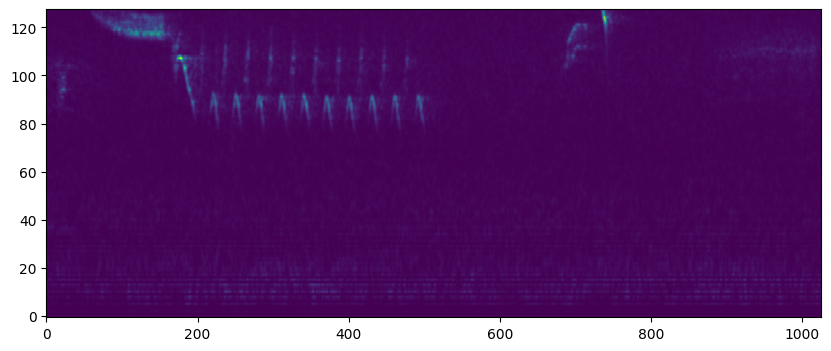

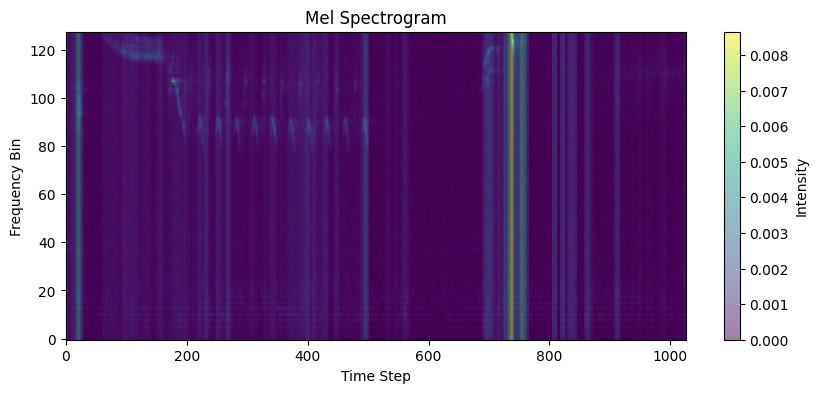

In [25]:
print("Misclassified as Melodia by CNN")
visualize_saliency_map(tf.keras.models.load_model('/content/model'), dataset_test, [346])

The CNN model is focusing on the distinct feature highlighted in yellow that appears only once in the Mel Spectrogram and mislabels the sound sample as melodia.

Correctly classified as Bewickii by CNN+RNN


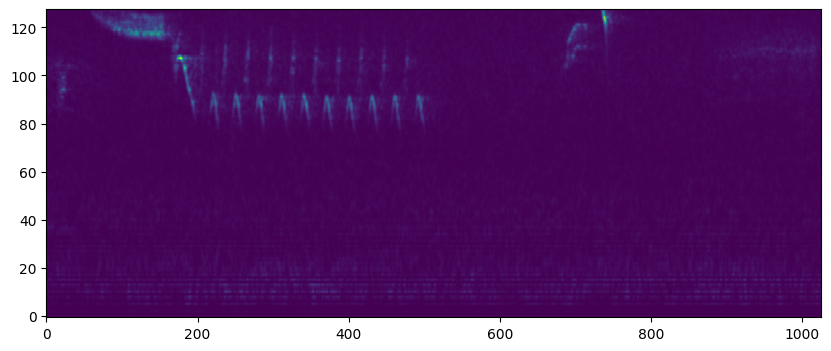

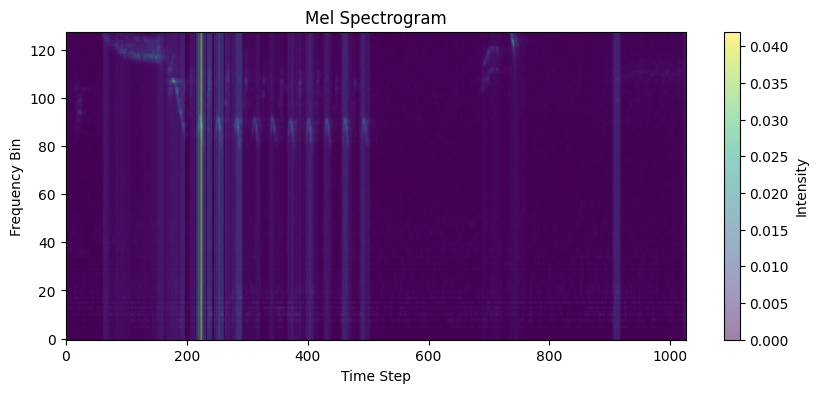

In [26]:
print("Correctly classified as Bewickii by CNN+RNN")
visualize_saliency_map(tf.keras.models.load_model('/content/model_v2'), dataset_test, [346])

RNN along with the attention layer in the CNN+RNN architecture directs the model to focus on the periodic features that appear on the mel spectrogram and thus correctly classifies the sound sample as bewickii. While listening to various sound samples and looking at the mel spectrogram simultaneously, one can observe that non-periodic distinct features on mel spectrogram typically correspond to sounds unrelated to bird vocalizations.

Misclassifications by both CNN and CNN+RNN


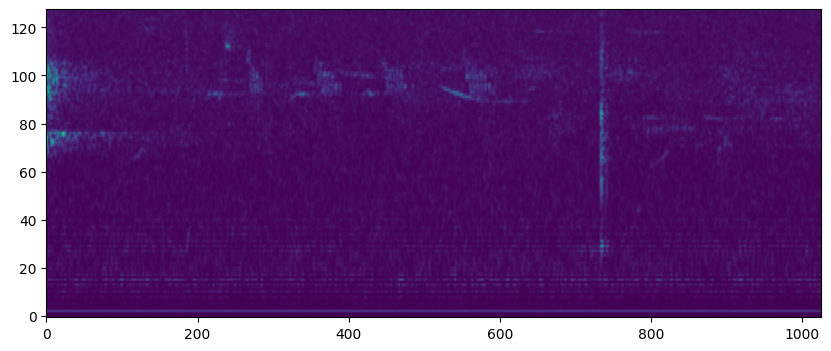

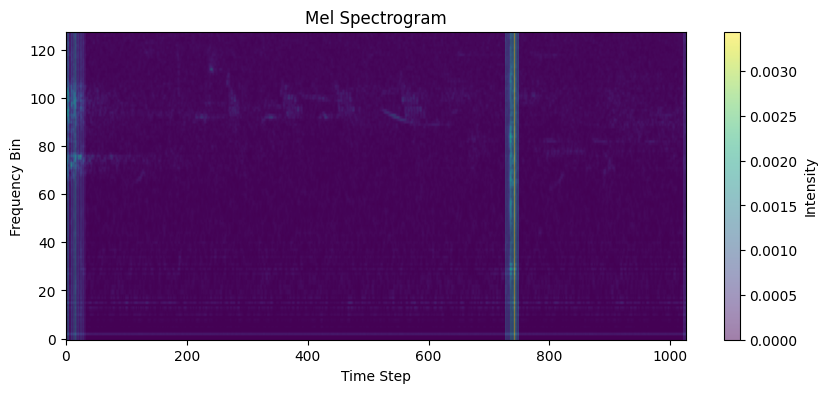

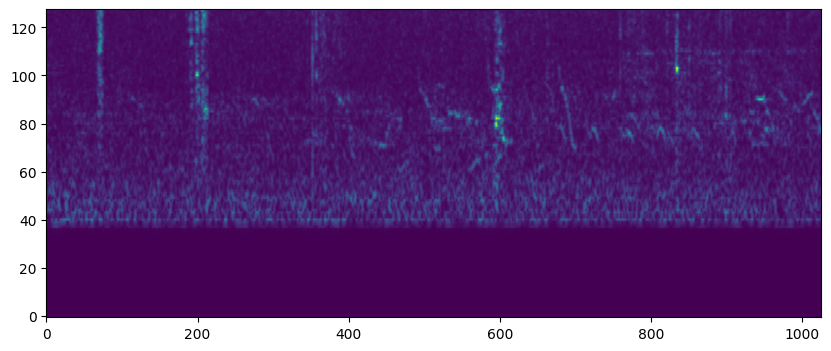

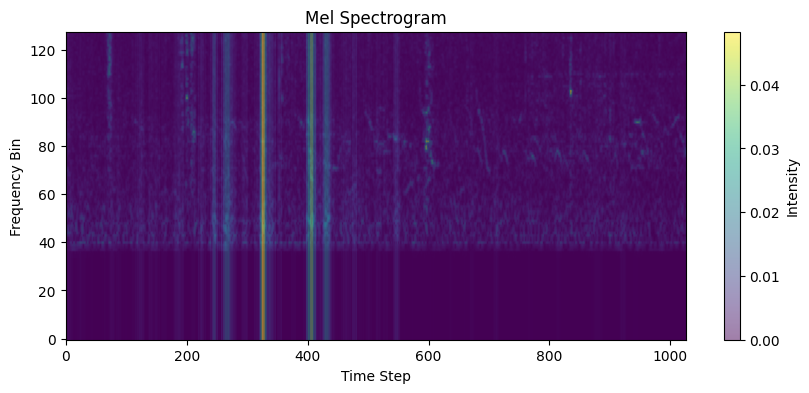

In [28]:
print("Misclassifications by both CNN and CNN+RNN")
visualize_saliency_map(tf.keras.models.load_model('/content/model_v2'), dataset_test, [455, 807])

The CNN+RNN model still misclassifies samples due to significant background noise. In these cases, the bird sound is often faint and overwhelmed by the surrounding noise. Thus, the model is compelled to focus on non-bird-related features, resulting in misclassification.